In [1]:
import os
import json
import gzip
import pandas as pd
from collections import defaultdict
import math
import scipy.optimize
from sklearn import svm
import numpy
import string
import random
import string
from sklearn import linear_model
import warnings
from dateutil import parser
import matplotlib.pyplot as plt

In [2]:
### load the meta data

data = []
with gzip.open('datasets/Kindle_Store_5.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))

In [3]:
random.shuffle(data)

train_data = data[:len(data)//2]
valid_data = data[len(data)//2:(3*(len(data)//4))]
test_data = data[(3*(len(data)//4)):]

In [4]:
def data_latent_form(entry):
    return [entry['reviewerID'], entry['asin'], entry['overall']]

In [5]:
train_data_latent = []
for d in train_data:
    train_data_latent.append(data_latent_form(d))

valid_data_latent = []
for d in valid_data:
    valid_data_latent.append(data_latent_form(d))

test_data_latent = []
for d in test_data:
    test_data_latent.append(data_latent_form(d))

In [6]:
ratings = []
for u,b,r in train_data_latent:
    ratings.append(int(r))

In [10]:
userRatings = defaultdict(list)
allRatings = []
for _,_,r in train_data_latent:
  r = int(r)
  allRatings.append(r)

globalAverage = sum(allRatings) / len(allRatings)

allRatings = []
for l in train_data_latent:
    allRatings.append(l)

reg = 10
MSE = 100

for reg_param in [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]:
    beta_u = defaultdict(int)
    beta_i = defaultdict(int)
    gamma_u = defaultdict(list)
    gamma_i = defaultdict(list)
    alpha = 0
    numberOfFeatures = 5
    for u,b,_ in allRatings:
        if not beta_u[u]: beta_u[u] = 0
        if not beta_i[b]: beta_i[b] = 0
        if not gamma_u[u]: gamma_u[u] = [0] * numberOfFeatures
        if not gamma_i[b]: gamma_i[b] = [0] * numberOfFeatures

    booksPerUser = defaultdict(set)
    usersPerBook = defaultdict(set)
    training_count = 0
    alpha_temp = 0
    beta_u_temp = 0
    beta_i_temp = 0
    
    for u,b,r in allRatings:
        gamma_prod = 0
        for j in range(len(gamma_u[u])):
            gamma_prod += (gamma_u[u][j] * gamma_i[b][j])
        r_pred = alpha + beta_u[u] + beta_i[b] + gamma_prod
        alpha_temp = ((training_count * alpha) + (r - r_pred + alpha))
        training_count += 1
        alpha_temp /=  training_count
        beta_u_temp = (((reg_param + len(booksPerUser[u])) * beta_u[u]) + (r - r_pred + beta_u[u]))
        beta_u_temp /= (reg_param + len(booksPerUser[u]) + 1)
        beta_i_temp = (((reg_param + len(usersPerBook[b])) * beta_i[b]) + (r - r_pred + beta_i[b]))
        beta_i_temp /= (reg_param + len(usersPerBook[b]) + 1)
        gamma_u_temp = []
        gamma_i_temp = []
        for j in range(len(gamma_u[u])):
            
            temp_u = (((reg_param + (len(booksPerUser[u]) * (gamma_i[b][j] ** 2))) * gamma_u[u][j]) + 
                    (gamma_i[b][j] * (r - r_pred + (gamma_u[u][j] * gamma_i[b][j]))))
            temp_i = (((reg_param + (len(usersPerBook[b]) * (gamma_u[u][j] ** 2))) * gamma_i[b][j]) + 
                    (gamma_u[u][j] * (r - r_pred + (gamma_u[u][j] * gamma_i[b][j]))))
            temp_u /= (reg_param + ((len(booksPerUser[u]) + 1) * (gamma_i[b][j] ** 2)))
            temp_i /= (reg_param + ((len(usersPerBook[b]) + 1) * (gamma_u[u][j] ** 2)))
            
            gamma_u_temp.append(temp_u)
            gamma_i_temp.append(temp_i)
        
        booksPerUser[u].add(b)
        usersPerBook[b].add(u)
        alpha = alpha_temp
        beta_u[u] = beta_u_temp
        beta_i[b] = beta_i_temp
        for j in range(len(gamma_u[u])):
            gamma_u[u][j] = gamma_u_temp[j]
            gamma_i[b][j] = gamma_i_temp[j]
    y  = []
    ypred = []
    for u,b,r in valid_data_latent:
        y.append(r)
        if u in beta_u and b in beta_i:
            gamma_prod = 0
            for j in range(len(gamma_u[u])):
                gamma_prod += (gamma_u[u][j] * gamma_i[b][j])
            ypred.append(alpha + beta_u[u] + beta_i[b] + gamma_prod)
        elif u in beta_u and not b in beta_i:
            ypred.append(alpha + beta_u[u])
        elif not u in beta_u and b in beta_i:
            ypred.append(alpha + beta_i[b])
        else:
            ypred.append(globalAverage)
        if ypred[-1] < 0 or ypred[-1] > 5:
            if ypred[-1] < 0: ypred[-1] = 0
            else: ypred[-1] = 5
        ypred[-1] = round(ypred[-1])
    y = numpy.array(y)
    ypred = numpy.array(ypred)
    validMSE = numpy.asarray(sum([x**2 for x in (y - ypred)])) / len(y)
    if validMSE < MSE:
        reg = reg_param
        MSE = validMSE


In [11]:
y = []
ypred = []
for u,b,r in test_data_latent:
    y.append(r)
    if u in beta_u and b in beta_i:
        gamma_prod = 0
        for j in range(len(gamma_u[u])):
            gamma_prod += (gamma_u[u][j] * gamma_i[b][j])
        ypred.append(alpha + beta_u[u] + beta_i[b] + gamma_prod)
    elif u in beta_u and not b in beta_i:
        ypred.append(alpha + beta_u[u])
    elif not u in beta_u and b in beta_i:
        ypred.append(alpha + beta_i[b])
    else:
        ypred.append(globalAverage)
    if ypred[-1] < 0 or ypred[-1] > 5:
        if ypred[-1] < 0: ypred[-1] = 0
        else: ypred[-1] = 5
    ypred[-1] = round(ypred[-1])
y = numpy.array(y)
ypred = numpy.array(ypred)
testMSE = numpy.asarray(sum([x**2 for x in (y - ypred)])) / len(y)
print(testMSE)
print(reg)

1.009194814916113
1


In [12]:
unverified = []
verified = []
for d in train_data:
    if d['verified']: verified.append(d)
    else: unverified.append(d)

In [13]:
ratings_verified = []
ratings_unverified = []
for d in verified:
    ratings_verified.append(d['overall'])
for d in unverified:
    ratings_unverified.append(d['overall'])
print(len(ratings_unverified))
print(len(ratings_verified))
print(len(ratings))

402617
708874
1111491


In [14]:
#Number of each rating

ones = 0
twos = 0
thre = 0
four = 0
five = 0
for r in ratings:
    if r == 1: ones+=1
    if r == 2: twos+=1
    if r == 3: thre+=1
    if r == 4: four+=1
    if r == 5: five+=1
print(ones)
print(twos)
print(thre)
print(four)
print(five)
print(ones + twos + thre)

# Number of ones, twos, and three rating combined is less than fours

23947
33308
98898
278124
677214
156153


In [15]:
#Number of each rating verified

ones = 0
twos = 0
thre = 0
four = 0
five = 0
for r in ratings_verified:
    if r == 1: ones+=1
    if r == 2: twos+=1
    if r == 3: thre+=1
    if r == 4: four+=1
    if r == 5: five+=1
print(ones)
print(twos)
print(thre)
print(four)
print(five)

18096
24520
67554
167315
431389


In [16]:
#Number of each rating unverified

ones = 0
twos = 0
thre = 0
four = 0
five = 0
for r in ratings_unverified:
    if r == 1: ones+=1
    if r == 2: twos+=1
    if r == 3: thre+=1
    if r == 4: four+=1
    if r == 5: five+=1
print(ones)
print(twos)
print(thre)
print(four)
print(five)

5851
8788
31344
110809
245825


In [17]:
#Number of users and books

print(len(usersPerBook))
print(len(booksPerUser))

98170
138452


In [18]:
print(globalAverage)

4.395737797247121


Latent factor model is biased towards 4's and 5's rating due excessive number of these ratings. So it predicts mostly around 4 and 5 rating.

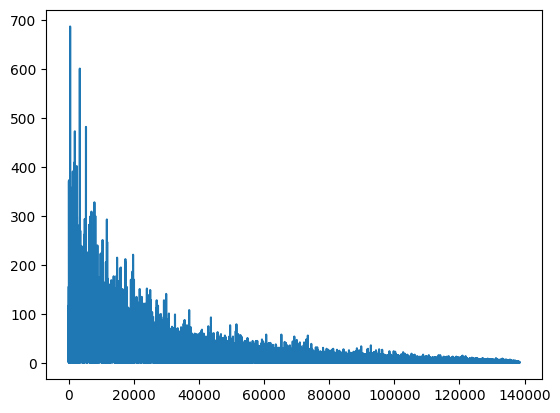

In [19]:
usersNumber = [] # List of number of users who read a particular book
booksNumber = [] # List of number of books read by a different users
for b in booksPerUser:
    booksNumber.append(len(booksPerUser[b]))

for u in usersPerBook:
    usersNumber.append(len(usersPerBook[u]))
plt.plot(booksNumber)

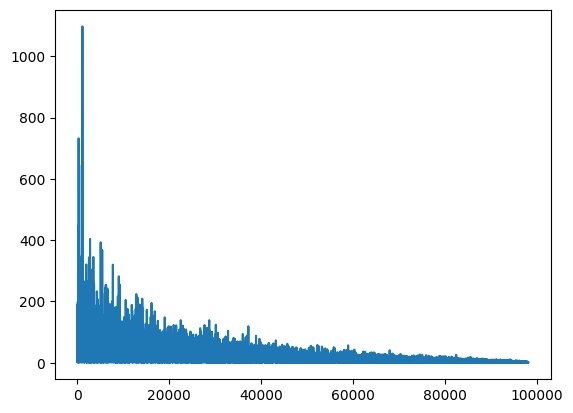

In [20]:
plt.plot(usersNumber)

In [21]:
ratingsOverTime = []
for d in train_data:
    ratingsOverTime.append([parser.parse(d['reviewTime']), d['overall']])
ratingsOverTime.sort()

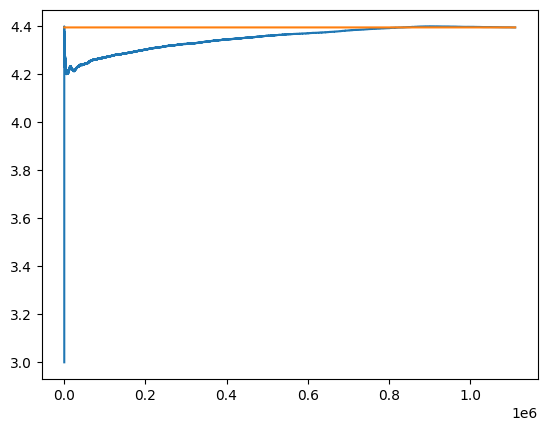

In [22]:
# Don't know why did this

ratingsSorted = []
globalAverageRating = []
avgRating = []
for date,r in ratingsOverTime:
    ratingsSorted.append(r)
ratingSum = 0
ratingLen = 1
for r in ratingsSorted:
    ratingSum += r
    avgRating.append(ratingSum / ratingLen)
    ratingLen += 1
    globalAverageRating.append(globalAverage)
plt.plot(avgRating)
plt.plot(globalAverageRating)

In [23]:
# Ratings using length of review text and summary

def feature_q2(datum):
    count = 0
    count_summ = 0
    try:
        datum1 = datum['reviewText']
        datum2 = datum['summary']
        for words in datum1:
            if words == ' ': continue
            else: count += 1
        for words in datum2:
            if words == ' ': continue
            else: count_summ += 1
        return [1] + [count] + [count_summ]
    except:
        return [1] + [12] + [3]

In [24]:
X_Q2 = numpy.matrix([feature_q2(d) for d in train_data])
Y_Q2 = numpy.matrix([d['overall'] for d in train_data]).T
model_Q2 = linear_model.LinearRegression(fit_intercept=False)
model_Q2.fit(X_Q2,Y_Q2)
X_test = numpy.matrix([feature_q2(d) for d in test_data])
Y_test = numpy.matrix([d['overall'] for d in test_data]).T
y_pred_Q2 = model_Q2.predict(X_test)
MSE_Q2 = numpy.asarray((sum([x**2 for x in (Y_test - y_pred_Q2)])) / len(Y_Q2))
mse_Q2 = MSE_Q2[0][0]


/home/amm/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/home/amm/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/home/amm/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [25]:
print(mse_Q2)

0.4283153746705394
